In [1]:
import glob
from typing import Union, Dict
from urllib.parse import unquote, quote_plus

import pandas as pd
# !pip install webdriver_manager

In [2]:
import time

import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By

In [72]:
electronic_household_items = [
    "television", "iron", "vacuum cleaner", "blender", "microwave", "toaster", "coffee maker",
    "dishwasher", "refrigerator", "oven", "washer", "dryer", "air conditioner", "heater", "fan",
    "hair dryer", "electric kettle", "rice cooker", "slow cooker", "pressure cooker", "food processor",
    "mixer", "juicer", "grill", "waffle maker", "sandwich maker", "popcorn maker", "ice cream maker",
    "electric griddle", "hot plate", "water purifier", "humidifier", "dehumidifier", "air purifier",
    "ceiling fan", "space heater", "robot vacuum", "cordless drill", "security camera", "smart doorbell",
    "smart lock", "thermostat", "smart light switch", "smart plug", "smart speaker", "sound bar",
    "home theater system", "streaming device", "gaming console", "router", "smart TV", "wireless charger",
    "Bluetooth speaker", "tablet", "e-reader", "smartphone", "smartwatch", "fitness tracker", "laptop",
    "desktop computer", "monitor", "keyboard", "mouse", "external hard drive", "USB flash drive",
    "headphones", "earbuds", "webcam", "digital camera", "camcorder", "drone", "smart light bulb",
    "electric toothbrush", "electric shaver", "hair straightener", "hair curler", "foot massager",
    "electric blanket", "electric skillet", "bread maker", "sous vide cooker", "food dehydrator",
    "electric wine opener", "electric can opener", "electric knife", "electric pressure washer",
    "smart refrigerator", "smart oven", "smart microwave", "robot lawn mower", "video doorbell",
    "smart garage door opener", "smart blinds", "smart irrigation system", "smart smoke detector",
    "smart carbon monoxide detector", "smart thermostat", "smart security system", "home automation hub",
    "smart scale", "robot mop", "smart ceiling fan", "smart alarm clock"
]

In [73]:
class Product:
    def __init__(self, product_id, name, category, price, description, about, brand, rating, image_url):
        self.product_id = product_id
        self.name = name
        self.price = price
        self.category = category
        self.description = description
        self.about = about
        self.brand = brand
        self.rating = rating
        self.image_url = image_url
        self.reviews = []

    def add_review(self, review):
        self.reviews.append(review)


In [74]:
class Review:
    def __init__(self, text: str):
        self.text: str = text

In [75]:
class ReviewScrapper:
    def __init__(self):
        options = Options()
        options.headless = True
        self.driver = webdriver.Chrome(options=options)

    def fetch_reviews(self, product_link):
        self.driver.get(product_link)
        time.sleep(5)
        reviews = []

        try:
            self.driver.find_element(By.PARTIAL_LINK_TEXT, "See more reviews").click()
            time.sleep(5)

            # Fetch reviews from the next page
            html_content = self.driver.page_source
            reviews.extend(self.parse_review_page(html_content))

            # Check for the next page link and click it
            next_page = self.driver.find_elements(By.CSS_SELECTOR, "li.a-last a")
            if next_page:
                next_page[0].click()
                time.sleep(5)  # Wait for the next page to load

                # Fetch reviews from the next page
                html_content = self.driver.page_source
                reviews.extend(self.parse_review_page(html_content))

        except Exception as e:
            print(f"Error fetching reviews: {e}")
        finally:
            self.cleanup()
        return reviews

    def parse_review_page(self, html_content):
        soup = BeautifulSoup(html_content, 'html.parser')
        review_texts = [tag.get_text(strip=True) for tag in soup.find_all('span', {'data-hook': 'review-body'})]
        return [Review(text) for text in review_texts]

    def cleanup(self):
        self.driver.quit()


In [76]:
class Scrapper:
    def __init__(self):
        self.keyword: Union[str | None] = None
        self.product_count: int = 11
        self.base_url: str = "https://www.amazon.ca"
        self.products: List[Product] = []
        self.skipped_categories: List[str] = []
        self.max_retries: int = 1
        self.categories: List[str] = electronic_household_items
        # self.categories: List[str] = [
        #     # "smart TV", 12-
        #     # "Bluetooth speaker",
        #     "tablet",
        #     # "e-reader", "smartphone", "smartwatch", "fitness tracker", "laptop",
        #     # "desktop computer", "monitor", "keyboard", "mouse", "external hard drive", "USB flash drive",
        #     # "smart plug", "smart speaker", "sound bar",
        # ]

        self.headers: Dict[str, str] = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
            'Accept-Language': 'en-US, en;q=0.5',
            'Accept-Encoding': 'gzip, deflate, br',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8',
            'Referer': 'https://www.google.com/',
        }

        # Initialize Selenium WebDriver
        options = Options()
        options.headless = True
        self.driver = webdriver.Chrome(options=options)

    def set_keyword(self, keyword: str):
        self.keyword = keyword

    def search_products(self):
        search_url = f"{self.base_url}/s?k={quote_plus(self.keyword)}"

        for _ in range(self.max_retries):
            try:
                response = requests.get(search_url, headers=self.headers)
                response.raise_for_status()
                print(search_url, response.status_code)

                if response.status_code == 200:
                    soup = BeautifulSoup(response.content, 'html.parser')
                    product_links = [
                        self.base_url + tag['href']
                        for tag in soup.find_all('a', {'class': 'a-link-normal s-no-outline'}, href=True)
                    ]

                    print(f"Found {len(product_links)} products")
                    return product_links[10:self.product_count]
                else:
                    print(f"Failed to fetch the search results. Status code: {response.status_code}")
            except requests.exceptions.RequestException as e:
                print(f"Exception Error fetching search results: {e}")
            except Exception as e:
                print(f"Error fetching search results: {e}")

            # Wait before retrying
            time.sleep(5)
            # If all retries fail, add the keyword to skipped categories
        self.skipped_categories.append(self.keyword)
        return []

    def extract_product_details(self, product_link: str):
        response = requests.get(product_link, headers=self.headers)

        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')

            try:
                category = self.keyword

                # Decode the URL to handle escaped characters
                decoded_url = unquote(product_link)

                # Regular expression pattern to match the ASIN in the URL
                asin_pattern = r'/dp/([A-Z0-9]{10})/'
                asin_match = re.search(asin_pattern, decoded_url)

                # Return the matched ASIN or None if no match is found
                product_id = asin_match.group(1) if asin_match else None

                name = soup.find(id="productTitle").get_text(strip=True)
                name = name.strip() if name else None

                brand = soup.select_one('tr.po-brand')
                brand = brand.get_text(strip=True).replace('Brand', '') if brand else None

                if brand is None:
                    brand = soup.select_one('a#bylineInfo')
                    brand = brand.get_text(strip=True).replace('Brand:', '') if brand else None

                # scrape product price
                price = soup.select_one('span.a-offscreen')
                price = price.text.replace('$', '') if price else None

                if not price:
                    price_whole = soup.select_one('span.a-price-whole').get_text(strip=True)
                    price_decimal = soup.select_one('span.a-price-fraction').get_text(strip=True)
                    price = f'{price_whole}.{price_decimal}'

                about = soup.find(id="feature-bullets").get_text(strip=True)
                about = about.strip() if about else None

                description = soup.select_one('#productDescription')
                description = description.text.strip() if description else None

                image_url = soup.find("img", {"id": "landingImage"})
                image_url = image_url['src'] if image_url else None

                # scrape product rating
                rating_element = soup.select_one('#acrPopover').attrs.get('title')
                rating = rating_element.replace('out of 5 stars', '') if rating_element else None

                return Product(
                    product_id=product_id,
                    name=name,
                    category=category,
                    price=price,
                    description=description,
                    about=about,
                    brand=brand,
                    rating=rating,
                    image_url=image_url
                )
            except AttributeError:
                print("Error parsing product details.")
                return None
        else:
            print("Failed to fetch the product page.")
            return None

    def aggregate_data(self):
        product_links = self.search_products()

        for link in product_links:
            product = self.extract_product_details(link)

            if product:
                self.products.append(product)
                review_scraper = ReviewScrapper()
                reviews = review_scraper.fetch_reviews(link)

                for review in reviews:
                    product.add_review(review)

    def save_to_csv(self, file_name: str):
        data = []
        columns = ['Id', 'Name', 'Category', 'Price', 'Description', 'About', 'Rating', 'ImageUrl', 'Brand', 'Review']

        if len(self.products) == 0:
            return

        for product in self.products:
            for review in product.reviews:
                data.append({
                    'Id': product.product_id,
                    'Name': product.name,
                    'Category': product.category,
                    'Price': product.price,
                    'Description': product.description,
                    'About': product.about,
                    'Rating': product.rating,
                    'ImageUrl': product.image_url,
                    'Brand': product.brand,
                    'Review': review.text,
                })

        df = pd.DataFrame(data, columns=columns)
        df.to_csv(file_name, index=False)

        # reset the current data
        self.products = []

        print(f"Data saved to {file_name}")

    def merge_csv(self):
        csv_files = glob.glob('./data/*.{}'.format('csv'))

        if len(csv_files) == 0:
            return

        dataset = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
        dataset.to_csv('amazon_electronics_products_reviews.csv', index=False)

        print(f"Data saved and merged.")

    def cleanup(self):
        self.driver.quit()

    def run(self):
        for category in self.categories:
            name = category.replace(' ', '_')
            file_name = f'./data/amazon_{name}_products_reviews.csv'
            self.set_keyword(category)
            self.aggregate_data()
            self.save_to_csv(file_name)

            time.sleep(5)

        self.cleanup()
        print(f'Skipped categories are: {self.skipped_categories}')
        self.merge_csv()


if __name__ == "__main__":
    scraper = Scrapper()
    scraper.run()



https://www.amazon.ca/s?k=tablet 200
Found 69 products
Data saved to ./data/amazon_tablet_products_reviews.csv
Skipped categories are: []


In [3]:
csv_files = glob.glob('./old/*.{}'.format('csv'))

dataset = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
dataset.to_csv('amazon_electronics_products_reviews.csv', index=False)

print(f"Data saved and merged.")

Data saved and merged.


In [26]:
import re
from typing import List
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# max_features=5000

class TextWrangler:
    def __init__(self):
        self.count = CountVectorizer()
        self.tf_idf_ = TfidfVectorizer()
        # Download stopwords if not already downloaded
        try:
            self.stop_words = set(stopwords.words('english'))
        except LookupError:
            import nltk
            nltk.download('stopwords')
            nltk.download('punkt')
            self.stop_words = set(stopwords.words('english'))

    @staticmethod
    def remove_digit(text: str) -> str:
        return re.sub(r'\d+', '', text)

    @staticmethod
    def remove_punctuations(text: str) -> str:
        return text.translate(str.maketrans('', '', string.punctuation))

    @staticmethod
    def clean_text(text: str) -> str:
        """
        Clean the text and remove punctuations.
        """
        text = re.sub('<.*?>', '', text)  # Remove HTML tags
        text = re.sub('[^A-Za-z0-9]+', ' ', text)  # Remove special characters
        return text.lower()

    @staticmethod
    def word_lengthening(text: str) -> str:
        """
        Fix a word by reducing any character repeated three or more times
        to just two instances of that character.
        """
        return re.sub(r'(.)\1{2,}', r'\1\1', text.strip())

    @staticmethod
    def tokenize(text: str) -> List[str]:
        """
        Tokenize the given text into words.
        """
        return word_tokenize(text)

    def remove_stopwords(self, text: str) -> str:
        """
        Remove stop words from a given text.
        """
        filtered_text = [word for word in self.tokenize(text) if word.lower() not in self.stop_words]
        return ' '.join(filtered_text)

    def init_bag_of_words(self, end_range: int):
        self.count = CountVectorizer(ngram_range=(1, end_range))
        return self.count

    def bag_of_words(self, text: List[str]):
        """
        Compute the Bag of Words matrix for the given list of texts.
        """
        return self.count.fit_transform(text)

    def init_tf_idf(self, end_range: int):
        self.tf_idf_ = TfidfVectorizer(ngram_range=(1, end_range))
        return self.tf_idf_

    def tf_idf(self, text: List[str]):
        """
        Compute the TF-IDF matrix for the given list of texts.
        """
        return self.tf_idf_.fit_transform(text)

    @staticmethod
    def plot_word_cloud(data, title):
        wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(
            data)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(title, fontsize=15)
        plt.axis('off')
        plt.show()
        return


In [18]:
# Example usage
text = "This is a sample text with goooood words and some stopwords. It also has digits like 123 and punctuations!"

tw = TextWrangler()
text_without_digits = tw.remove_digit(text)
print("Text without digits:", text_without_digits)

text_without_punctuations = tw.remove_punctuations(text)
print("Text without punctuations:", text_without_punctuations)

fixed_text = tw.word_lengthening("Goooood")
print("Fixed word:", fixed_text)

filtered_text = tw.remove_stopwords(text)
print("Text without stop words:", filtered_text)

tokens = tw.tokenize(text)
print("Tokens:", tokens)

texts = ["This is the first document.", "This document is the second document.", "And this is the third one."]
tfidf_matrix = tw.tf_idf(texts)
print("TF-IDF matrix:", tfidf_matrix.toarray())

tfidf_matrix_3 = tw.tf_idf(texts)
print("TF-IDF matrix:", tfidf_matrix_3.toarray())
print("TF-IDF matrix:", tw.tf.vocabulary_)

bow_matrix = tw.bag_of_words(texts)
print("Bag of Words matrix:", bow_matrix.toarray())
print("BOW:", tw.count.vocabulary_)

bow_matrix_3 = tw.init_bag_of_words(3)
bow_matrix_3 = tw.bag_of_words(texts)

print("Bag of Words matrix:", bow_matrix_3.toarray())

Text without digits: This is a sample text with goooood words and some stopwords. It also has digits like  and punctuations!
Text without punctuations: This is a sample text with goooood words and some stopwords It also has digits like 123 and punctuations
Fixed word: Good
Text without stop words: sample text goooood words stopwords . also digits like 123 punctuations !
Tokens: ['This', 'is', 'a', 'sample', 'text', 'with', 'goooood', 'words', 'and', 'some', 'stopwords', '.', 'It', 'also', 'has', 'digits', 'like', '123', 'and', 'punctuations', '!']
TF-IDF matrix: [[0.         0.46941728 0.61722732 0.3645444  0.         0.
  0.3645444  0.         0.3645444 ]
 [0.         0.7284449  0.         0.28285122 0.         0.47890875
  0.28285122 0.         0.28285122]
 [0.49711994 0.         0.         0.29360705 0.49711994 0.
  0.29360705 0.49711994 0.29360705]]
TF-IDF matrix: [[0.         0.46941728 0.61722732 0.3645444  0.         0.
  0.3645444  0.         0.3645444 ]
 [0.         0.7284449 

Data Loading and Exploration

In [10]:
df = pd.read_csv('amazon_electronics_products_reviews.csv')

In [11]:
df.head()

,Id,Name,Category,Price,Description,Rating,ImageUrl,Brand,Review,About
0,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,NaN,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,"This machine, although plastic, is sturdy and ...",NaN
1,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,NaN,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,This washer has it all. my clothing is washed ...,NaN
2,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,NaN,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,My order came early😃 This machine does a great...,NaN
3,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,NaN,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,Im really happy with this machine. It works gr...,NaN
4,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,NaN,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,I was surprised how aggressive the wash cycle ...,NaN


In [12]:
df.shape

(5098, 10)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5098 entries, 0 to 5097
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id           5098 non-null   object 
 1   Name         5098 non-null   object 
 2   Category     5098 non-null   object 
 3   Price        5098 non-null   object 
 4   Description  2511 non-null   object 
 5   Rating       5098 non-null   float64
 6   ImageUrl     5098 non-null   object 
 7   Brand        5098 non-null   object 
 8   Review       5090 non-null   object 
 9   About        20 non-null     object 
dtypes: float64(1), object(9)
memory usage: 398.4+ KB


In [14]:
df.describe()

,Rating
count,5098.000000
mean,4.332032
std,0.271662
min,1.000000
25%,4.200000
50%,4.400000
75%,4.500000
max,5.000000


Data Cleaning

In [17]:
nan_count = df['Price'].isna().sum()
nan_count

0

In [33]:
# Calculate mean prices by category
mean_prices = df.groupby('Category')['Price'].mean()
# 
# # Fill missing prices with respective category mean
# df['Price'] = df.apply(lambda row: mean_prices[row['Category']] if pd.isnull(row['Price']) else row['Price'], axis=1)


In [18]:
nan_count = df['Price'].isna().sum()
nan_count

0

In [19]:
# Drop rows with NaN values in 'Price'
df.dropna(subset=['Price'], inplace=True)

In [20]:
nan_count = df['Price'].isna().sum()
nan_count

0

In [21]:
# Handle missing values if any
df.fillna('', inplace=True)  # Fill NaNs with empty string for text columns

# Ensure 'Price' is numeric (convert if necessary)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

df.head()

,Id,Name,Category,Price,Description,Rating,ImageUrl,Brand,Review,About
0,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,"This machine, although plastic, is sturdy and ...",
1,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,This washer has it all. my clothing is washed ...,
2,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,My order came early😃 This machine does a great...,
3,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,Im really happy with this machine. It works gr...,
4,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,I was surprised how aggressive the wash cycle ...,


Text Preprocessing

In [22]:
text_wrangler = TextWrangler()

In [23]:
df['Description'] = (df['Description']
                     .apply(text_wrangler.remove_digit)
                     .apply(text_wrangler.remove_punctuations)
                     .apply(text_wrangler.clean_text)
                     .apply(text_wrangler.word_lengthening)
                     .apply(text_wrangler.remove_stopwords))

df['Review'] = (df['Review']
                .apply(text_wrangler.remove_digit)
                .apply(text_wrangler.remove_punctuations)
                .apply(text_wrangler.clean_text)
                .apply(text_wrangler.word_lengthening)
                .apply(text_wrangler.remove_stopwords))

df['About'] = (df['About']
               .apply(text_wrangler.remove_digit)
               .apply(text_wrangler.remove_punctuations)
               .apply(text_wrangler.clean_text)
               .apply(text_wrangler.word_lengthening)
               .apply(text_wrangler.remove_stopwords))

df.head()

,Id,Name,Category,Price,Description,Rating,ImageUrl,Brand,Review,About
0,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,machine although plastic sturdy seems well mad...,
1,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,washer clothing washed dried within hour spinn...,
2,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,order came early machine great job washing clo...,
3,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,im really happy machine works greati set tub c...,
4,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,surprised aggressive wash cycle seems good bit...,


World Cloud

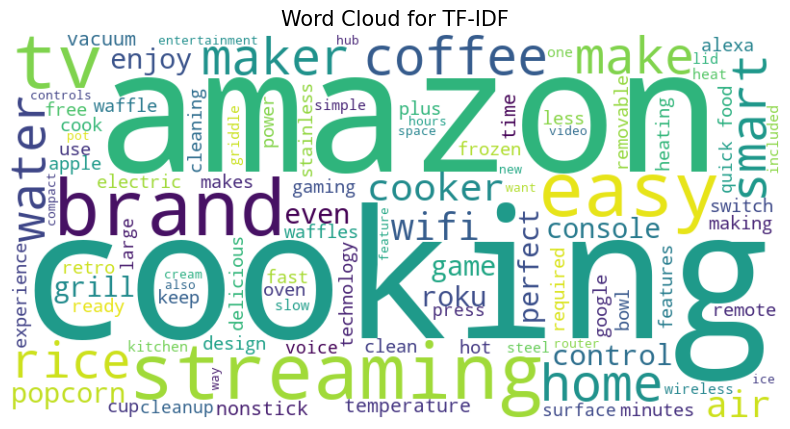

In [32]:
# Fit and transform the 'Description' and 'Review' columns

X_description_tfidf = text_wrangler.tf_idf(df['Description'])
X_about_tfidf = text_wrangler.tf_idf(df['About'])
X_review_tfidf = text_wrangler.tf_idf(df['Description'])

X_description_tfidf_df = pd.DataFrame(
    X_description_tfidf.toarray(), columns=text_wrangler.tf_idf_.get_feature_names_out()
)

# Calculate the sum of TF-IDF scores for each word
tfidf_word_frequency = X_description_tfidf_df.sum(axis=0).sort_values(ascending=False)

# Plot word cloud for TF-IDF
text_wrangler.plot_word_cloud(tfidf_word_frequency, 'Word Cloud for TF-IDF')


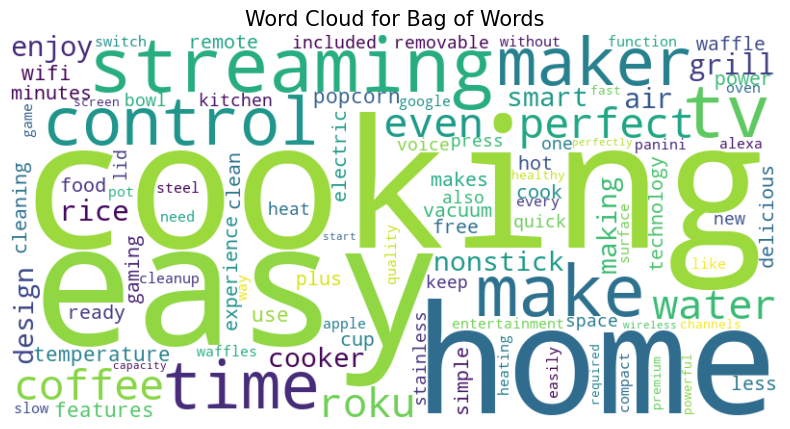

In [31]:
# Fit and transform the 'Description' and 'Review' columns

X_description_bow = text_wrangler.bag_of_words(df['Description'])
X_about_bow = text_wrangler.bag_of_words(df['About'])
X_review_bow = text_wrangler.bag_of_words(df['Description'])

X_description_bow_df = pd.DataFrame(X_description_bow.toarray(), columns=text_wrangler.count.get_feature_names_out())

# Calculate the sum of word counts for each word
bow_word_frequency = X_description_bow_df.sum(axis=0).sort_values(ascending=False)

# Plot word cloud for Bag of Words
text_wrangler.plot_word_cloud(bow_word_frequency, 'Word Cloud for Bag of Words')

Sentiment Analysis

In [6]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob


class TextSentimentAnalysis:
    def __init__(self):
        self.sid = SentimentIntensityAnalyzer()

    def get_sentiment_via_vader(self, text: str) -> float:
        scores = self.sid.polarity_scores(text)
        # Using compound score as a single sentiment score
        return scores['compound']

    @staticmethod
    def get_sentiment_via_textblob(text: str) -> float:
        """
            method to get sentiment scores
            returns polarity score as sentiment value
        """
        blob = TextBlob(text)
        return blob.sentiment.polarity


In [131]:
text_sentiment_analysis = TextSentimentAnalysis()

In [132]:
import pandas as pd

# Applying sentiment
df['ReviewSentiment'] = df['Review'].apply([text_sentiment_analysis.get_sentiment_via_vader])
df['DescriptionSentiment'] = df['Description'].apply(text_sentiment_analysis.get_sentiment_via_vader)
df['AboutSentiment'] = df['About'].apply(text_sentiment_analysis.get_sentiment_via_vader)

df.head()

,Id,Name,Category,Price,Description,Rating,ImageUrl,Brand,Review,About,ReviewSentiment,DescriptionSentiment,AboutSentiment,ValueCategory
0,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,machine although plastic sturdy seems well mad...,,0.8957,0.0,0.0,High
1,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,washer clothing washed dried within hour spinn...,,0.6486,0.0,0.0,High
2,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,order came early machine great job washing clo...,,0.8860,0.0,0.0,High
3,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,im really happy machine works great set tub co...,,0.9728,0.0,0.0,High
4,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,surprised aggressive wash cycle seems good bit...,,0.8934,0.0,0.0,High


In [ ]:
# Apply sentiment analysis to 'Description', About and 'Review' columns
# data['DescriptionSentiment_2'] = data['Description'].apply(get_sentiment_via_textblob)
# data['ReviewSentiment_2'] = data['Review'].apply(get_sentiment_via_textblob)
# data['AboutSentiment_2'] = data['About'].apply(get_sentiment_via_textblob)

In [133]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Prepare features and target variable
X = df[['DescriptionSentiment', 'ReviewSentiment', 'AboutSentiment']]
y = df['Price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 27387.639103486657


In [138]:
# Group by 'Category' and calculate average price
_mean_prices = mean_prices.reset_index()

# Print average prices per category (optional)
print("Average Prices per Category:")
print(_mean_prices)

# Calculate threshold based on average price
thresholds = {}
for index, row in _mean_prices.iterrows():
    category = row['Category']
    avg_price = row['Price']

    std_dev = df[df['Category'] == category]['Price'].std()
    threshold = avg_price + std_dev

    thresholds[category] = '{0:.2f}'.format(threshold)

print("\nThresholds per Category:")
for category, threshold in thresholds.items():
    print(f"{category}: {threshold}")


Average Prices per Category:
               Category       Price
0     Bluetooth speaker  163.554286
1       air conditioner  299.056129
2          coffee maker  143.100000
3            dishwasher  381.658333
4                 dryer  159.990000
5      electric griddle   49.430777
6       electric kettle   61.382517
7        gaming console  180.900260
8                 glass   32.390000
9                 grill  161.666667
10           headphones  131.214444
11  home theater system  292.495000
12            hot plate   82.665745
13      ice cream maker  146.737143
14               juicer   77.704286
15               laptop  608.370952
16            microwave  115.385000
17                mixer   85.716718
18                 oven  208.719508
19        popcorn maker   68.877143
20         refrigerator  289.102500
21          rice cooker  179.438101
22               router   61.460391
23       sandwich maker   44.454286
24          slow cooker  117.585000
25             smart TV  452.990000

In [68]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define high/low value based on price threshold
df['ValueCategory'] = df['Price'].apply(lambda x: 'High' if x > threshold else 'Low')

# Prepare features and target variable
X = df[['DescriptionSentiment', 'ReviewSentiment']]
y = df['ValueCategory']

# Encode categorical target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split df into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize and train a random forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Decode predictions if needed
y_pred_category = le.inverse_transform(y_pred)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8260869565217391
